<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Information-Bottleneck-for-Decision-Trees" data-toc-modified-id="Information-Bottleneck-for-Decision-Trees-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Information Bottleneck for Decision Trees</a></span><ul class="toc-item"><li><span><a href="#Decision-Trees-as-Learning-an-Optimal-Encoding" data-toc-modified-id="Decision-Trees-as-Learning-an-Optimal-Encoding-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Decision Trees as Learning an Optimal Encoding</a></span></li><li><span><a href="#Questions" data-toc-modified-id="Questions-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Questions</a></span></li></ul></li><li><span><a href="#TODO" data-toc-modified-id="TODO-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>TODO</a></span></li><li><span><a href="#Implementation" data-toc-modified-id="Implementation-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Implementation</a></span><ul class="toc-item"><li><span><a href="#Optimal-split" data-toc-modified-id="Optimal-split-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Optimal split</a></span><ul class="toc-item"><li><span><a href="#Loss:-entropy" data-toc-modified-id="Loss:-entropy-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Loss: entropy</a></span></li><li><span><a href="#Loss:-Categorical-Information-Bottleneck" data-toc-modified-id="Loss:-Categorical-Information-Bottleneck-3.1.2"><span class="toc-item-num">3.1.2&nbsp;&nbsp;</span>Loss: Categorical Information Bottleneck</a></span></li></ul></li><li><span><a href="#Tree" data-toc-modified-id="Tree-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Tree</a></span></li><li><span><a href="#Train" data-toc-modified-id="Train-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Train</a></span><ul class="toc-item"><li><span><a href="#Circle-regularized-with-IB,-$\beta=0.1$" data-toc-modified-id="Circle-regularized-with-IB,-$\beta=0.1$-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Circle regularized with IB, $\beta=0.1$</a></span></li><li><span><a href="#Circle,-regularized-with-max_depth=20" data-toc-modified-id="Circle,-regularized-with-max_depth=20-3.3.2"><span class="toc-item-num">3.3.2&nbsp;&nbsp;</span>Circle, regularized with <code>max_depth=20</code></a></span></li><li><span><a href="#Circle,-regularized-with-min_n" data-toc-modified-id="Circle,-regularized-with-min_n-3.3.3"><span class="toc-item-num">3.3.3&nbsp;&nbsp;</span>Circle, regularized with <code>min_n</code></a></span></li><li><span><a href="#Easy-data" data-toc-modified-id="Easy-data-3.3.4"><span class="toc-item-num">3.3.4&nbsp;&nbsp;</span>Easy data</a></span></li><li><span><a href="#Evaluate-Probability-to-end-up-in-a-leave-with-leave-size-N" data-toc-modified-id="Evaluate-Probability-to-end-up-in-a-leave-with-leave-size-N-3.3.5"><span class="toc-item-num">3.3.5&nbsp;&nbsp;</span>Evaluate Probability to end up in a leave with leave size N</a></span></li></ul></li><li><span><a href="#Utils" data-toc-modified-id="Utils-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Utils</a></span></li></ul></li><li><span><a href="#Scratch-Pad" data-toc-modified-id="Scratch-Pad-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Scratch Pad</a></span></li></ul></div>

# Information Bottleneck for Decision Trees

Decision trees are a class of machine learning algorithms that can be used for classification and regression problems. From an information theoretical perspective, they can be viewed as algorithms to construct optimal binary encodings $e: \mathcal{X} \mapsto \mathcal{B} $ for $\mathcal{B}$ being the set of binary words, and $\mathcal{X}$ being data sampled of an unkown distribution $P_X : \mathcal{X} \mapsto [0, 1]$.
It is interesting to analyze this in the information bottleneck framework (IB), which gives a justification to expect generalization.

**Objective of IB**
The IB objective is given as
$$ J'(e) = \beta I(X, e(X)) - I(e(X), y)  = \beta ( H(X) - H(X|e(X) ) - H(y) + H(y|e(X)) $$
If we ignore all terms independent of $e$, we get:
$$ J(e) =  H(y|e(X)) - \beta H(X|e(X)) $$

It is straight forward to apply the IB method to decision trees. The first term  $H(y|e(X))$ is a widely used objective in decision trees, and the second term $\beta H(X|e(X))$ serves as a regularizer. 

In the fitting phase, the tree tries to find a binary split $f(x) = x_i > t$ such that $J(f)$ is minimal. If the optimal split is a constant function over the samples, all points are grouped into the same split and the (sub)tree is a leaf. In this way, pruning is no longer necessary.

The loss function for a non-leaf tree can be expressed as:


$$  J = H(y|e(X)) - \beta H(X|e(X)) $$
$$ = \sum_{i=0}^1 ( P(e(X)=i) * (H(y|e(X)=i) - \beta H(X|e(X)=i)) ) $$
$$ = P(e(X)=0) * J(left) + P(e(X)=1) * J(right) $$

The loss of a leaf is simply:

$$    J = H(y|e(X)) - \beta H(X|e(X)) $$
$$      = H(y) - \beta H(X) $$

To estimate $H(X)$, we simply assume a uniform distribution over all samples, i.e. $-log(N)$.


This allows an efficient recursive computation of the loss.

- doing it in the split vs doing it as pruning

Generalization: IB and VC dimension

Prior of decision trees
- features are interpretable by themselves, which e.g. does not apply to images

Tradeoff: more flexible prior via new features vs increased VC dimension

Can we find an upper bound for $I(X, e(X)) \leq \psi(D)$?

## Decision Trees as Learning an Optimal Encoding

Decision trees are a class of machine learning algorithms that can be used for classification and regression problems. During training, a decision tree is fitted by greedily finding binary rules of the type $f(x) = x_i > t$. Here, $x \in R^D$ is a sample of the distribution $P_X$, and the objective is to find $f$ such that $I(X, f(X))$ is maximized.

This can be seen from an information theoretic perspective as constructing a 

## Questions
- How to deal with regression?
    - We need to approximate the differential entropy of y
    - Do we get an upper or lower bound by estimating p_y?
- Is the classification tree optimal in the sense of cross entropy?
- Is the regression tree optimal in the sense of MSE?
- Can we optimize for arbitrary loss functions?
    - Yes, and we can still use $\beta I(X, e(X))$ as regularizer


# TODO
- Mean only for regression trees, otherwise return probability distribution
- Print tree recursively
- Experiment: center data and reuse the same trees at a lower cost
- differential entropy
- optimal beta given N, d?
- plot2d

# Implementation

In [1]:
from scipy.special import xlogy
import numpy as np
from matplotlib import pyplot as plt


def entropy(y):
    """Return the empirical entropy of samples y of 
    a categorical distribution

    Arguments:
        y: np.array (N, C) , categorical labels
    Returns:
        H: float
    """
    if len(y) == 0:
        return 0
    py = y.mean(0)
    h = -np.sum(xlogy(py, py))
    return h


def plot_entropy_of_bernoulli():
    p = []
    h = []
    for t in range(1000):
        p += [t/1000]
        y = np.zeros((1000, 2))
        y[:t,0]=1
        y[t:,1]=1
        h += [entropy(y)]

    plt.plot(p, h)
    plt.xlabel("t")
    plt.ylabel("H")
    plt.title("Entropy of Bernoulli_t")
    plt.show()
    
plot_entropy_of_bernoulli()

<Figure size 640x480 with 1 Axes>

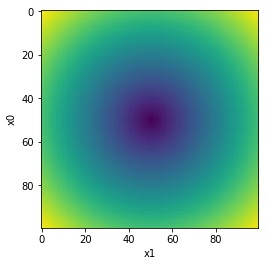

In [81]:
def grid2d(N):
    """
    Create an (N*N, 2) matrix of samples on a grid of [0,1]x[0,1]
    """
    X = np.zeros((N*N, 2))
    X[:,0] = np.repeat(np.arange(0, 1, 1/N), N)
    X[:,1] = np.arange(0, N, 1/N) % 1
    return X-np.array([0.5,0.5])

X = grid2d(100)
y = np.linalg.norm(X, axis=1)

def plot_on_grid(y, N):
    plt.imshow(y.reshape((N, N)))
    plt.xlabel("x1")
    plt.ylabel("x0")
    plt.show()
    
plot_on_grid(y, 100)

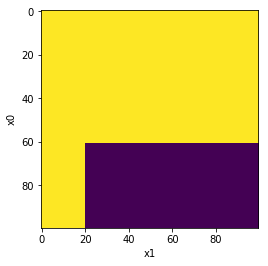

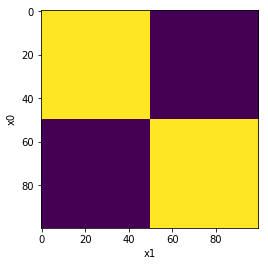

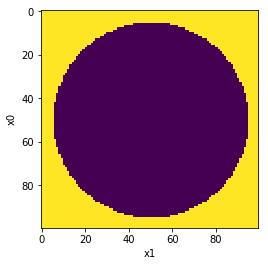

(array([[-0.5 , -0.5 ],
        [-0.5 , -0.49],
        [-0.5 , -0.48],
        ...,
        [ 0.49,  0.47],
        [ 0.49,  0.48],
        [ 0.49,  0.49]]), array([[1., 0.],
        [1., 0.],
        [1., 0.],
        ...,
        [1., 0.],
        [1., 0.],
        [1., 0.]]))

In [82]:
def easy_data():
    X = grid2d(100)
    y = np.zeros((10000, 2))
    y[X[:,0]<0.1,0] = 1
    y[X[:,1]<-0.3,0] = 1
    y[:,1] = 1 - y.sum(1)
    plot_on_grid(y[:,0], 100)
    return X, y
easy_data()

def caro_data():
    X = grid2d(100)
    y = np.zeros((10000, 2))
    y[(X[:,0]<0) == (X[:,1]<0),0] = 1
    y[:,1] = 1 - y.sum(1)
    plot_on_grid(y[:,0], 100)
    return X, y
caro_data()

def circle_data():
    X = grid2d(100)
    y = np.zeros((10000, 2))
    y[np.square(X).sum(1) > 0.2, 0] = 1
    y[:,1] = 1 - y.sum(1)
    plot_on_grid(y[:,0], 100)
    return X, y
circle_data()

## Optimal split

In [5]:
def smooth(y, window=None, mode='valid'):
    window = window or min(max(len(y)//30, 2), 20)
    return np.convolve(np.ones(window)/window, y, mode=mode)

In [95]:
def optimal_split_plot(X, y, J):
    plt.figure(figsize=(14, 6))
    c=plt.rcParams['axes.prop_cycle'].by_key()['color']
    N, d = X.shape
    for i in range(d):
        x = X[:,i]
        sort = np.argsort(x)
        x, y = x[sort], y[sort]
        best_loss = np.inf
        best_split_idx = 0
        h = []
        eval_treshhold = np.unique(x)
        for t in eval_treshhold:
            # evaluate loss for splitting [:s], [s:]
            y_l = y[x<=t]
            y_r = y[x>t]
            s = len(y_l)
            loss = J(y_l)*s/N + J(y_r)*(N-s)/N
            h.append(loss)
        
        plt.subplot(121)
        plt.plot(eval_treshhold, h, label=i, color=c[i])
        plt.subplot(122)
        plt.plot(smooth(y[:,0], window=len(y)//10), color=c[i])
        plt.plot(smooth(y[:,1], window=len(y)//10), color=c[i])
    
    plt.subplot(121)
    plt.xlabel("Threshhold")
    plt.ylabel("Loss")
    plt.legend()
    plt.subplot(122)
    plt.xlabel("Split index")
    plt.ylabel("Y")
    plt.show()



### Loss: entropy

In [ ]:
X, y = easy_data()
optimal_split_plot(X, y, entropy)
X, y = caro_data()
optimal_split_plot(X, y, entropy)
X, y = circle_data()
optimal_split_plot(X, y, entropy)

### Loss: Categorical Information Bottleneck

In [92]:
def categorical_IB(beta):
    def J(y):
        if len(y) == 0:
            return 0
        return entropy(y) - beta*np.log(len(y))
    return J

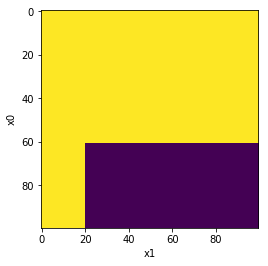

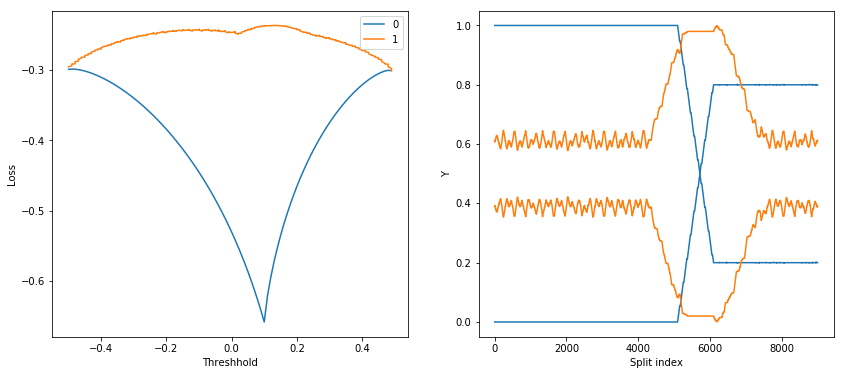

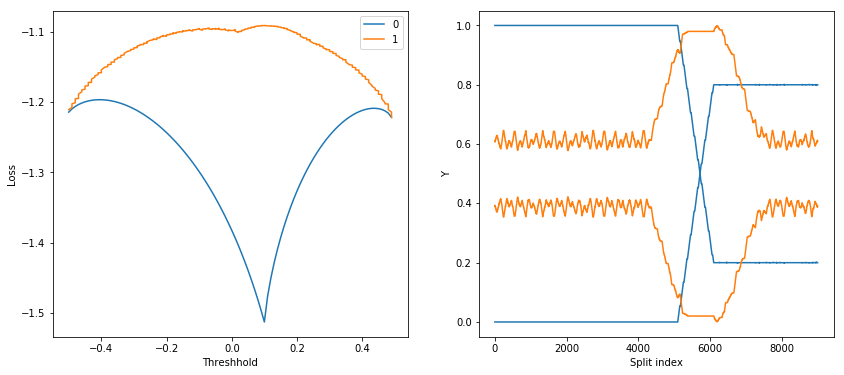

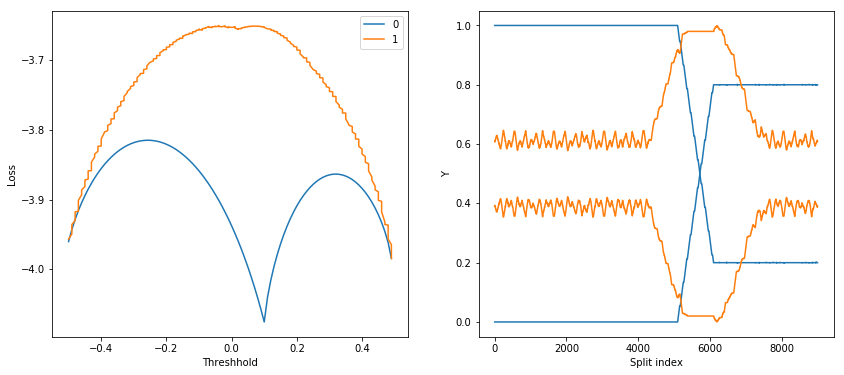

In [94]:
X, y = easy_data()
optimal_split_plot(X, y, categorical_IB(0.1))
optimal_split_plot(X, y, categorical_IB(0.2))
optimal_split_plot(X, y, categorical_IB(0.5))

## Tree

In [120]:
import pdb


def differential_entropy(y):
    pass

def optimal_split(x, y, J, min_n):
    N = len(x)
    best_loss = np.inf
    best_t = -np.inf
    for t in np.unique(x)[::max(1, len(x)//100)]:
        # evaluate loss for splitting [:s], [s:]
        y_l = y[x<=t]
        y_r = y[x>t]
        s = len(y_l)
        loss = J(y_l)*s/N + J(y_r)*(N-s)/N
        if loss < best_loss and s>=min_n and s<=N-min_n:
            best_loss = loss
            best_t = t
    return best_t, best_loss


def categorical_IB(beta):
    def J(y):
        if len(y) == 0:
            return 0
        return entropy(y) - beta*np.log(len(y))
    return J


class DecisionTree():
    def __init__(self, J, _prefix="Tree", root=None, min_n=10, max_depth=1000):
        self.split_dim = 0
        self.J = J
        self.root = root or self
        self.min_n = min_n
        self.max_depth = max_depth
        self.threshhold = -np.inf
        self.loss = np.inf
        self.leaf_loss = np.inf
        self.left = None
        self.right = None
        self.mean = None
        self._N = None
        self._prefix=_prefix
        self.n_leaves = 1
        self.depth = 1

    @property
    def is_leaf(self):
        return self.left is None and self.right is None
    
    def check_input(self, X, y):
        assert (len(X) == len(y) and X.ndim==2 and y.ndim==2), f"Unexpected shapes: \n  X: {X.shape}\n  y: {y.shape}"
        assert y.sum(1).mean() == 1, "Expected one hot encoded labels"
        
    def fit(self, X, y):
        self.check_input(X, y)
        self.mean = y.mean(axis=0)
        self._N = len(X)
        self.leaf_loss = self.J(y)
        N, d = X.shape
        if self.mean.max() == 1 or N < self.min_n or self.max_depth < 1:
            self.loss = self.leaf_loss
            return self
        best_t_idx = None
        for i in range(d):
            t, j = optimal_split(X[:, i], y, self.J, self.min_n)
            if j < self.loss:
                self.threshhold, self.loss, self.split_dim = t, j, i
                
        if self.loss < self.leaf_loss:
            self.left = DecisionTree(
                self.J,
                _prefix=f"{self._prefix} and \\ \n    x[{self.split_dim}] <= {self.threshhold}",
                root=self.root,
                min_n=self.min_n,
                max_depth=self.max_depth-1
            )
            self.left.fit(
                X[X[:, self.split_dim] <= self.threshhold],
                y[X[:, self.split_dim] <= self.threshhold]
            )
            self.right = DecisionTree(
                self.J,
                _prefix=f"{self._prefix} and \\ \n    x[{self.split_dim}] > {self.threshhold}",
                root=self.root,
                min_n=self.min_n,
                max_depth=self.max_depth-1
            )
            self.right.fit(
                X[X[:, self.split_dim] > self.threshhold],
                y[X[:, self.split_dim] > self.threshhold]
            )
            self.loss = self.left.loss * (self.left._N / self._N) + \
                self.right.loss * (self.right._N / self._N)
            self.n_leaves = self.left.n_leaves + self.right.n_leaves
            self.depth = max(self.left.depth, self.right.depth) + 1
        else:
            self.loss = self.leaf_loss
        return self
    
    def print_node(self, prefix=""):
        print(f"{prefix} >> N: {self._N}")
        print(f"{prefix} >> J: {self.leaf_loss:.2f}")
        print(f"{prefix} >> Acc: {self.mean.max():.2f}")
        
    def print_tree(self, prefix=""):
        if self.is_leaf:
            self.print_node(prefix)
        else:
            print(f"{prefix} X_{self.split_dim} <= {self.threshhold} : {self.left._N} vs {self._N-self.left._N}")
            self.left.print_tree(prefix+"  |")
            if self.right is not None:
                print(f"{prefix} X_{self.split_dim} > {self.threshhold}")
                self.right.print_tree(prefix+"  |")
                
    def get_leaves(self):
        if self.is_leaf:
            return [self]
        return self.left.get_leaves() + self.right.get_leaves()
                
    def plot_2d_tree(self):
        pass

    def encode_single(self, x):
        pass

    def predict_single(self, x):
        if self.is_leaf:
            return self.mean
        if x[self.split_dim] < self.threshhold:
            return self.left.predict_single(x)
        else:
            return self.right.predict_single(x)
        
    def predict(self, X):
        return np.array([self.predict_single(x) for x in X])

    def color_single(self, x, depth):
        if self.is_leaf or depth==0:
            return 0
        if x[self.split_dim] < self.threshhold:
            return self.left.color_single(x, depth-1) - self.depth
        else:
            return self.right.color_single(x, depth-1) + self.depth
        
    def color(self, X, depth=None):
        depth = depth or self.depth
        return np.array([self.color_single(x, depth) for x in X])
        

## Train


### Circle regularized with IB, $\beta=0.1$

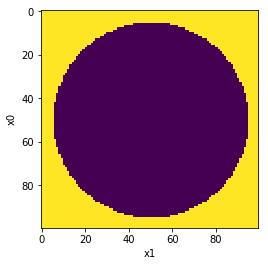

 X_0 <= -0.5 : 100 vs 9900
  | >> N: 100
  | >> J: -0.46
  | >> Acc: 1.00
 X_0 > -0.5
  | X_1 <= 0.4299999999999997 : 9266 vs 634
  |  | X_0 <= 0.43000000000000005 : 8708 vs 558
  |  |  | X_1 <= -0.2999999999999998 : 1884 vs 6824
  |  |  |  | X_1 <= -0.41999999999999815 : 837 vs 1047
  |  |  |  |  | X_1 <= -0.4499999999999993 : 529 vs 308
  |  |  |  |  |  | >> N: 529
  |  |  |  |  |  | >> J: -0.63
  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  |  | X_1 > -0.4499999999999993
  |  |  |  |  |  | X_0 <= -0.15999999999999998 : 102 vs 206
  |  |  |  |  |  |  | >> N: 102
  |  |  |  |  |  |  | >> J: -0.46
  |  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  |  |  | X_0 > -0.15999999999999998
  |  |  |  |  |  |  | X_0 <= 0.15000000000000002 : 122 vs 84
  |  |  |  |  |  |  |  | X_1 <= -0.44999999999999574 : 29 vs 93
  |  |  |  |  |  |  |  |  | >> N: 29
  |  |  |  |  |  |  |  |  | >> J: -0.34
  |  |  |  |  |  |  |  |  | >> Acc: 1.00
  |  |  |  |  |  |  |  | X_1 > -0.44999999999999574
  |  |  |  |  |  |  |  

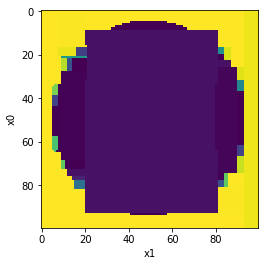

Tree with 68 leaves and depth of 20


In [101]:
tree = DecisionTree(categorical_IB(beta=0.1))
X, y = circle_data()
tree.fit(X, y)
tree.print_tree()
y_pred = tree.predict(X)
plot_on_grid(y_pred[:,0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

### Circle, regularized with `max_depth=20`

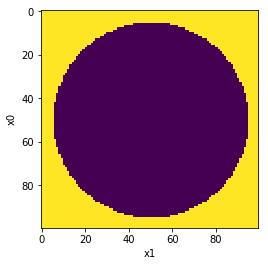

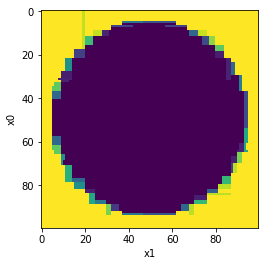

Tree with 117 leaves and depth of 18


In [104]:
tree = DecisionTree(entropy, max_depth=20)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)
plot_on_grid(y_pred[:,0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

### Circle, regularized with `min_n`

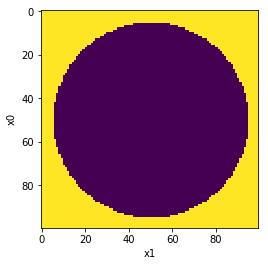

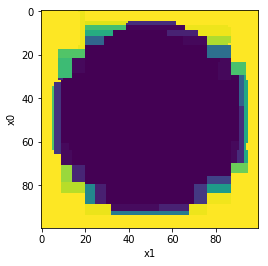

Tree with 68 leaves and depth of 16


In [109]:
tree = DecisionTree(entropy, min_n=40)
X, y = circle_data()
tree.fit(X, y)
y_pred = tree.predict(X)
plot_on_grid(y_pred[:,0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")

### Easy data

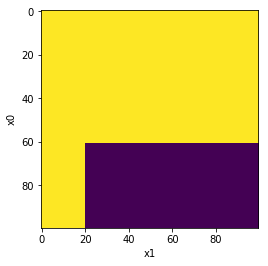

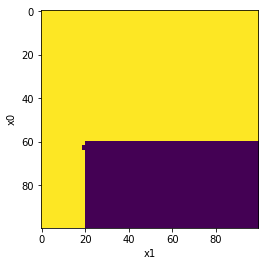

Tree with 8 leaves and depth of 8
D = 1


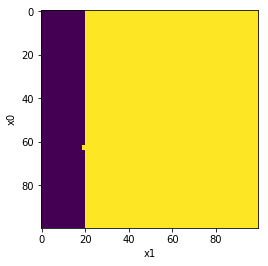

D = 2


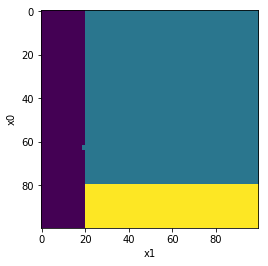

D = 3


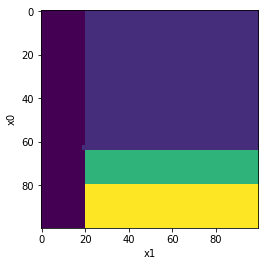

D = 4


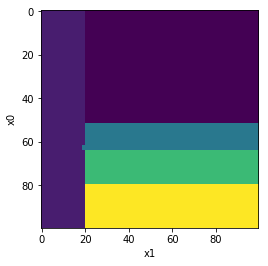

D = 5


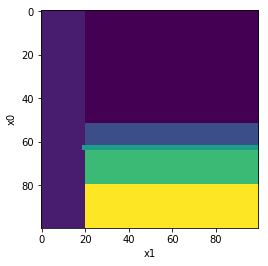

D = 6


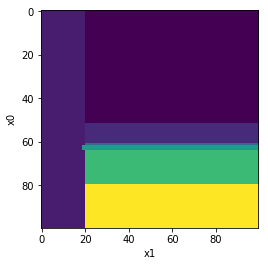

D = 7


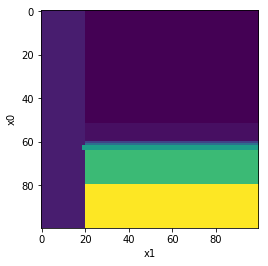

In [123]:
tree = DecisionTree(categorical_IB(beta=0), max_depth=40)
X, y = easy_data()
tree.fit(X, y)
y_pred = tree.predict(X)
plot_on_grid(y_pred[:,0], 100)

print(f"Tree with {tree.n_leaves} leaves and depth of {tree.depth}")
for d in range(1, 8):
    print("="*30)
    print(f"D = {d}")
    structure = tree.color(X, depth=d)
    plot_on_grid(structure, 100)

### Evaluate Probability to end up in a leave with leave size N

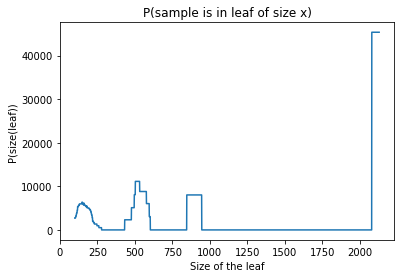

In [70]:
def fill_missing_x_with(x, y, fill=0):
    c = dict(zip(x.tolist(), y.tolist()))
    x = np.arange(x.min(), x.max()+0.5, 1)
    y = np.array([c.get(s, 0)*s for s in x])
    return x, y


leaves = tree.get_leaves()
leaf_size = [i._N for i in leaves]
sizes, counts = np.unique(leaf_size, return_counts=True)
x, p_in_leav_of_size = fill_missing_x_with(sizes, sizes*counts, fill=0)
plt.plot(x, smooth(p_in_leav_of_size, mode='same', window=100))
plt.xlabel("Size of the leaf")
plt.ylabel("P(size(leaf))")
plt.title("P(sample is in leaf of size x)")
plt.show()




## Utils

In [ ]:

import pdb
def debug(f):
    def debugged(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except Exception as e:
            print(type(e), e)
            pdb.set_trace()
            f(*args, **kwargs)
    return debugged

# Scratch Pad

In [ ]:
tree.print_tree()

In [ ]:
optimal_split(X[:,5], y, categorical_IB(0))